#Sentiment Analysis of drug reviews

---



####Sentiment Analysis is an algorithm in Natural Language Processing which is used to detect sentiment within sequence of text (Sentence). In this work, I have choose to work on analysing drug reviews provided by the patients. The reviews are in the form of text. Along with drugs reviews, the input also contains ratings corresponding to each reviews on a scale from 1-10. The input datasets are obtained from UCI machine learning repository. This is my first attempt to use deep learning model, in which I am using Feed forward neural network to analyze the drug reviews and provide prediction whether the particular drug review is positive or negative. I will also be using different performance metrics like accuracy and loss test the performance.

#####Retrieve the input files from the google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#####Load the necessary input libraries

In [2]:
import numpy as np
import pandas as pd

# importing the libraries for deep learning models
import keras 
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.metrics import Precision
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Embedding, SpatialDropout1D, Bidirectional
from sklearn.metrics import accuracy_score

# importing the libraries for stemming
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

#from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from tensorflow.keras import optimizers
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#####Read the input files to pandas dataframe

In [3]:
df_train = pd.read_csv('/content/gdrive/My Drive/drugs_dataset/drugsComTrain_raw.tsv', sep='\t')
df_test  = pd.read_csv('/content/gdrive/My Drive/drugs_dataset/drugsComTest_raw.tsv', sep='\t')

# getting the shapes
print("Shape of train :", df_train.shape)
print("Shape of test :", df_test.shape)

Shape of train : (161297, 7)
Shape of test : (53766, 7)


#####Validating the dataframe if the data read properly using head function

In [4]:
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


#####Validating the test dataframe if the data read properly using head function

In [5]:
df_test.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


#####Concatenating both the train and test dataframe for better visualization

In [6]:
complete_input_data = pd.concat([df_train, df_test])

#####Checking the shape of concatenating dataframe

In [7]:
complete_input_data.shape

(215063, 7)

#####Using iter() function 
#####NB. The function helps with large datasets as it is memory-efficient since it does not load the entire dataset into memory at once.

In [8]:
drug_iter = iter(complete_input_data.values.tolist())

In [9]:
# This will print the first two rows of the dataset as lists using next()
row_1 = next(drug_iter)
row_2 = next(drug_iter)

print(row_1)
print(row_2)


[206461, 'Valsartan', 'Left Ventricular Dysfunction', '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"', 9.0, 'May 20, 2012', 27]
[95260, 'Guanfacine', 'ADHD', '"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."', 8.0, 'April 27, 2010', 192]


#####Checking the sample 5 records using head

In [10]:
# checking the sample of new dataset

complete_input_data.head(5)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


#####Describing the input concetnated dataset

In [11]:
complete_input_data.describe()

,Unnamed: 0,rating,usefulCount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


#####Checking the datatype of the fields of concatenating dataframe

In [12]:
complete_input_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   215063 non-null  int64  
 1   drugName     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


#####Validating if the input datasets has null

In [13]:
complete_input_data.isnull().any()

Unnamed: 0     False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

#####Perform feature eng step to convert the rating to polarities, positive (1) and negative(0)

In [14]:
complete_input_data.loc[(complete_input_data['rating'] >= 7), 'Review_Sentiment'] = 1
complete_input_data.loc[(complete_input_data['rating'] < 7), 'Review_Sentiment'] = 0

complete_input_data['Review_Sentiment'].value_counts()

1.0    142306
0.0     72757
Name: Review_Sentiment, dtype: int64

#####Checking the dataframe for nulls

In [15]:
complete_input_data['condition'].isnull().sum()

1194

#####Removing the records with nulls so the model fitting does not have issues

In [16]:
complete_input_data = complete_input_data.dropna(axis = 0)

##### Clean up text with RegEx

In [17]:
# Clean up text with RegEx
pd.set_option('display.width', 1000)
rx_pat = r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(\d\s)|(\d)|(\/)"
#rx_pat_wSpace = r"(\-)|(\\)|(\s{2,})"
    
complete_input_data['review'].replace(regex=True,inplace=True,to_replace=rx_pat, value=r'')
#df_main['review'].replace(regex=True,inplace=True,to_replace=rx_pat_wSpace, value=r' ')
complete_input_data.review.head(5)

0    It has no side effect I take it in combination...
1    My son is halfway through his fourth week of I...
2    I used to take another oral contraceptive whic...
3    This is my first time using any form of birth ...
4    Suboxone has completely turned my life around ...
Name: review, dtype: object

#####Performing the step to remove stopwords

In [18]:
# Performing the step to remove stopwords..This will be used by Snowball Stemmer

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

#####Checking the columns of the input dataframe using columns command

In [19]:
#Checking the columns of the input dataframe using columns command
complete_input_data.columns

Index(['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'Review_Sentiment'], dtype='object')

#####Checking the shape of the input dataframe

In [20]:
#Checking the shape of the input dataframe
complete_input_data.shape

(213869, 8)

#####Inline function to perform Snowball stemmer

In [21]:
#Inline function to perform Snowball stemmer
stemmer = SnowballStemmer('english')

def words_review(base_review):
    # This step deletes HTML
    base_review_text = BeautifulSoup(base_review, 'html.parser').get_text()
    # This step makes a space
    just_letters = re.sub('[^a-zA-Z]', ' ', base_review_text)
    # This step is for lower letters
    words = just_letters.lower().split()
    # This step is for Stopwords 
    relevant_words = [w for w in words if not w in stops]
    # This step performs stemming
    stem_words = [stemmer.stem(w) for w in relevant_words]
    # This step perform the function to join
    return( ' '.join(stem_words))

In [22]:
#Each review is passed to the inline stemming function for cleaning
%time complete_input_data['clean_review'] = complete_input_data['review'].apply(words_review)

CPU times: user 2min 12s, sys: 1.14 s, total: 2min 14s
Wall time: 2min 13s


#### Check the datatypes of the dataframe after adding the field clean_review

In [23]:
#Check the datatypes of the dataframe after adding the field clean_review
complete_input_data.dtypes

Unnamed: 0            int64
drugName             object
condition            object
review               object
rating              float64
date                 object
usefulCount           int64
Review_Sentiment    float64
clean_review         object
dtype: object

####Describe the dataframe

In [24]:
#Describe the dataframe
complete_input_data.describe

<bound method NDFrame.describe of        Unnamed: 0                  drugName                     condition                                             review  rating                date  usefulCount  Review_Sentiment                                       clean_review
0          206461                 Valsartan  Left Ventricular Dysfunction  It has no side effect I take it in combination...     9.0        May 20, 2012           27               1.0      no side effect take combin bystol mg fish oil
1           95260                Guanfacine                          ADHD  My son is halfway through his fourth week of I...     8.0      April 27, 2010          192               1.0  son halfway fourth week intuniv becam concern ...
2           92703                    Lybrel                 Birth Control  I used to take another oral contraceptive whic...     5.0   December 14, 2009           17               0.0  use take anoth oral contracept pill cycl happi...
3          138000         

#### Performing the step to split the input dataframe to test and train

In [25]:
# Performing the step to split the input dataframe to test and train

df_train, df_test, y_train, y_test = train_test_split(complete_input_data, complete_input_data['Review_Sentiment'], test_size = 0.25, random_state = 0)

# checking the shape 
print("Shape of train:", df_train.shape)
print("Shape of test: ", df_test.shape)

print("Shape of train:", y_train.shape)
print("Shape of test: ", y_test.shape)

Shape of train: (160401, 9)
Shape of test:  (53468, 9)
Shape of train: (160401,)
Shape of test:  (53468,)


#### Converting the type to integer

In [26]:
# Converting the type to integer
y_train.astype(int)

24875     1
160919    1
45565     0
18904     0
48369     1
         ..
16650     0
118627    0
13357     1
43831     1
39150     1
Name: Review_Sentiment, Length: 160401, dtype: int64

#### Performing the step to convert the reviews in text format to vectors

In [27]:
# Performing the step to convert the reviews in text format to vectors
cv = CountVectorizer(max_features = 6000, ngram_range = (4, 4))
pipeline = Pipeline([('vect',cv)])

df_train_features = pipeline.fit_transform(df_train['clean_review'])
df_test_features = pipeline.transform(df_test['clean_review'])

print("df_train_features :", df_train_features.shape)
print("df_test_features :", df_test_features.shape)


df_train_features : (160401, 6000)
df_test_features : (53468, 6000)


#FNN Model

In [28]:
# Custom function
# Performing the step to define the model
def create_FNN_model(dropout_rate=0.5):
# Model Structure
    model = keras.models.Sequential()

# Add the layers to the model 
    model.add(keras.layers.Dense(200, input_shape=(6000,)))
    model.add(keras.layers.BatchNormalization())

# Add the activation function relu
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(dropout_rate))

# Add the layers to the model
    model.add(keras.layers.Dense(300))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))

# Add the dropout layer to the model
    model.add(keras.layers.Dropout(dropout_rate))

    model.add(keras.layers.Dense(100, activation = 'relu'))
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))

#  Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

##### Keras Classifier

In [29]:
model = KerasClassifier(build_fn=create_FNN_model)

<ipython-input-29-6e7c2d8d0c84>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_FNN_model)


####Convert the features from sparse_csr_matrix to numpy array

In [30]:
#convert the features from sparse_csr_matrix to np.array
df_train_features = df_train_features.toarray()

In [31]:
type(df_train_features)

numpy.ndarray

In [32]:
#checking the column 'clean_review'
df_train['clean_review']

24875     olux topic medic ive use abl control psoriasi ...
160919    quotbeach babi drop beach althrough high schoo...
45565     except drug pain relief side effect far outwei...
18904     take doxi rickettsia feel like crap no energi ...
48369     year social anxietypan attack sort research sn...
                                ...                        
16650     clindess didnt work sure expens doctor prescri...
118627    suffer fibromyalgia year diagnos offici two ib...
13357     use elmiron sinc februari love think gain weig...
43831     im year old ive medic year mood temper life ge...
39150     would good thing say strattera could got pass ...
Name: clean_review, Length: 160401, dtype: object

####Perform the step to fit the baseline model for training

In [33]:
#Perform the step to fit the model for training
FNN = model.fit(df_train_features, y_train.astype(int), epochs=20, validation_split=0.1, batch_size=64)


Epoch 1/20
2256/2256 [==============================] - 23s 7ms/step - loss: 0.6222 - accuracy: 0.6713 - val_loss: 0.5911 - val_accuracy: 0.6936
Epoch 2/20
2256/2256 [==============================] - 14s 6ms/step - loss: 0.5792 - accuracy: 0.6965 - val_loss: 0.5840 - val_accuracy: 0.6929
Epoch 3/20
2256/2256 [==============================] - 14s 6ms/step - loss: 0.5645 - accuracy: 0.7039 - val_loss: 0.5808 - val_accuracy: 0.6949
Epoch 4/20
2256/2256 [==============================] - 14s 6ms/step - loss: 0.5560 - accuracy: 0.7078 - val_loss: 0.5823 - val_accuracy: 0.6960
Epoch 5/20
2256/2256 [==============================] - 14s 6ms/step - loss: 0.5484 - accuracy: 0.7110 - val_loss: 0.5785 - val_accuracy: 0.6975
Epoch 6/20
2256/2256 [==============================] - 14s 6ms/step - loss: 0.5419 - accuracy: 0.7135 - val_loss: 0.5774 - val_accuracy: 0.6991
Epoch 7/20
2256/2256 [==============================] - 14s 6ms/step - loss: 0.5366 - accuracy: 0.7167 - val_loss: 0.5847 - val_ac

#### Converting the test features to numpy array

In [34]:
df_test_features = df_test_features.toarray()

#### Perform the step to do prediction on the model

In [35]:
prediction = model.predict(df_test_features)
print(prediction)

1671/1671 [==============================] - 4s 2ms/step
[[0]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


In [36]:
# Predict the classes of the test data
y_pred = model.predict(df_test_features)

# Calculate the accuracy score
accuracy = accuracy_score(y_test.astype(int), y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100))

1671/1671 [==============================] - 3s 2ms/step
Accuracy: 70.21%


##Perform the visualization graphs of Feed Forward Neural Network

#### Perform the loss metric graph on training

Text(0.5, 1.0, 'Training loss curve Vs Validation Loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

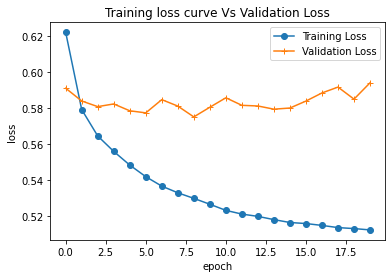

In [37]:
# Training Loss - training

import matplotlib.pyplot as plt

plt.plot(FNN.history['loss'],'-o')
plt.plot(FNN.history['val_loss'],'-+')
plt.title('Training loss curve Vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

#### Perform the accuracy metric graph - on training

Text(0.5, 1.0, 'Training accuracy curve Vs Validation Loss curve')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

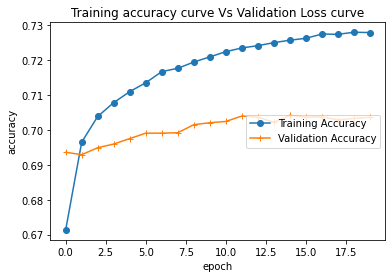

In [38]:
# Training Accuracy - on training

import matplotlib.pyplot as plt

plt.plot(FNN.history['accuracy'],'-o')
plt.plot(FNN.history['val_accuracy'],'-+')
plt.title('Training accuracy curve Vs Validation Loss curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='center right')
plt.show()

#####END OF MODEL